### Import Libraries

In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torch.quantization import quantize_dynamic
import time
import io
import matplotlib.pyplot as plt

### Load the Pre-trained model and dataset

In [19]:
# 1. Load pretrained model
model_fp32 = resnet18(pretrained=True)
model_fp32.eval()

# 2. Load ImageNet-Mini Dataset (subset of ImageNet validation)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

imagenet_mini_path = '/home/mcw/Downloads/archive/imagenet-mini/val'
dataset = torchvision.datasets.ImageFolder(imagenet_mini_path, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)


/home/mcw/Desktop/Quantization/quant_venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mcw/Desktop/Quantization/quant_venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Accuracy, Model-size and Latency Helper functions

In [20]:
# Evaluation function
def evaluate(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

# Model size function
def get_model_size(model):
    buffer = io.BytesIO()
    torch.save(model.state_dict(), buffer)
    return buffer.getbuffer().nbytes / 1e6  # in MB

### Quantization and Evaluation of the models

##### Convolutions need pre-quantized activations for speed, conv layers use spatial kernels sliding across input features. To make them fast with int8, both inputs and weights must be pre-quantized. But DQ quantizes activations on the fly (i.e., dynamically), which is too slow for convolution. So it negates any performance gain.

In [21]:
# ---- Evaluation before quantization ----
acc_fp32 = evaluate(model_fp32, loader) * 100
size_fp32 = get_model_size(model_fp32)

# ---- Apply dynamic quantization ----
model_int8 = quantize_dynamic(model_fp32, {torch.nn.Linear}, dtype=torch.qint8)

# ---- Evaluation after quantization ----
acc_int8 = evaluate(model_int8, loader) * 100
size_int8 = get_model_size(model_int8)


In [22]:
# ---- Print Results ----
print(f"\nFP32 Accuracy: {acc_fp32:.2f}%")
print(f"INT8 Accuracy (DQ): {acc_int8:.2f}%")
print(f"\nFP32 Model Size: {size_fp32:.2f} MB")
print(f"INT8 Model Size (DQ): {size_int8:.2f} MB")


FP32 Accuracy: 69.97%
INT8 Accuracy (DQ): 69.82%

FP32 Model Size: 46.83 MB
INT8 Model Size (DQ): 45.30 MB


### Comparision Results

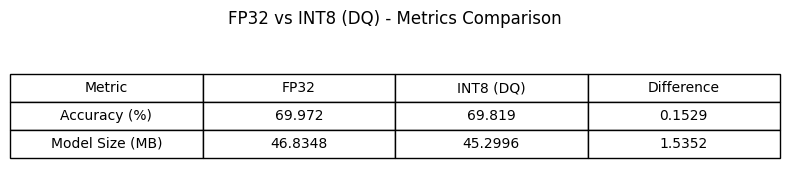

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'Metric': ['Accuracy (%)', 'Model Size (MB)'],
    'FP32': [acc_fp32, size_fp32],
    'INT8 (DQ)': [acc_int8, size_int8],
    'Difference': [acc_fp32 - acc_int8, size_fp32 - size_int8]
}

df = pd.DataFrame(data)
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('off')
table = ax.table(cellText=df.round(4).values, colLabels=df.columns, cellLoc='center', loc='center')
table.scale(1, 2)
plt.title("FP32 vs INT8 (DQ) - Metrics Comparison", fontsize=12, pad=20)
plt.tight_layout()
plt.show()
